In [1]:
from model import *
from AliLoader import *
from ALI_Out import *

from torch.utils.data import DataLoader
import torchvision.datasets as dset
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import manifold
from sklearn import metrics
from scipy import stats
from AliMisc import *

from skopt.space import Real, Integer
from skopt import Optimizer

import seaborn as sns

def GetAlphaRedMap(cmap):
    #Print Rebuild
    # Get the colormap colors
    AlphaRed = cmap(np.arange(cmap.N))
    # Set alpha
    AlphaRed[:,-1] = np.linspace(0, 1, cmap.N)
    # Create new colormap
    AlphaRed = ListedColormap(AlphaRed)
    return(AlphaRed)
AlphaRed = GetAlphaRedMap(plt.cm.Reds)

In [2]:
def GetAlphaRedMap(cmap):
    #Print Rebuild
    # Get the colormap colors
    AlphaRed = cmap(np.arange(cmap.N))
    # Set alpha
    AlphaRed[:,-1] = np.linspace(0, 1, cmap.N)
    # Create new colormap
    AlphaRed = ListedColormap(AlphaRed)
    return(AlphaRed)
AlphaRed = GetAlphaRedMap(plt.cm.Reds)
AlphaBllue = GetAlphaRedMap(plt.cm.Blues)

In [3]:

LS = 512 #Latent Space Size
ColorsNumber = 1 #Number of color (always 1 for x-ray)
isize = 64

name = "Exp_64_512_0.00001_RandomLabel_4.0"

datadir = "/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/"

ExpDir = "./model/"+name



In [4]:
batch_size = 25
TestDF = pd.read_csv(ExpDir+"/TestImagesInfo.csv")


PreProDir = datadir+"PreProcess/Size"+str(isize)
test_dataset = XrayDatasetTensor(PreProDir+"/Tensor"+str(isize)+".pt",PreProDir+"/AllImagesInfo.csv",list(TestDF["name"]))
RealLoader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

#DiseaseDF = TestDF[TestDF["no_finding"] != 1]
#disease_dataset = XrayDatasetTensor(PreProDir+"/Tensor"+str(isize)+".pt",PreProDir+"/AllImagesInfo.csv",list(DiseaseDF["name"]))
#DiseaseLoader = DataLoader(disease_dataset, shuffle=False, batch_size=batch_size)
#len(disease_dataset)

In [5]:

CP = -2 #Checkpoint to load (-2 for latest one, -1 for last epoch)
DisX,DisZ,DisXZ,GenZ,GenX,CP,DiscriminatorLoss,AllAUCs = GenModel(isize,LS,-2,ExpDir,name,ColorsNumber=ColorsNumber)

DisX = DisX.eval()
DisZ = DisZ.eval()
DisXZ = DisXZ.eval()
GenZ = GenZ.eval()
GenX = GenX.eval()



I found this last checkpoint 2121000


In [6]:
def OutScore(DisX,DisZ,DisXZ,GenZ,GenX,X):
    z = GenZ(X)
    Xr = GenX(z)
    
    
    DiffX = Xr - X
    
    if torch.cuda.is_available():
        DiffX = DiffX.cpu()
    
    DiffX = DiffX.detach().numpy()
    DiffX = np.power(DiffX,2)
    RecLoss = [np.sqrt(np.mean(x)) for x in DiffX]

    return(RecLoss,Xr.detach().numpy(),DiffX)

In [7]:
datadir

'/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/'

In [8]:
#Get BBOX
BBox = pd.read_csv(datadir+"BBox_List_2017.csv").dropna(axis=1)

In [9]:
BBox.columns = ["Image Index","lab","x","y","w","h"]
BBox.index = BBox["Image Index"]

In [10]:
bbox = BBox.transpose().to_dict()

/media/vince/anaconda3/envs/xray/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  if __name__ == '__main__':


In [11]:
def TransformPImg(pim,inputsize,ar):
    tx = ar[0]
    ty = ar[1]
    rot = ar[2]
    sc = ar[3]
    brightness_factor = ar[4]
    contrast_factor = ar[5]
    tim = transforms.functional.affine(pim,angle=rot, translate=[tx,ty], 
                                                   scale=1, shear=0, resample=0, fillcolor=0)
    
    tim = transforms.functional.adjust_brightness(tim, brightness_factor)
    tim = transforms.functional.adjust_contrast(tim, contrast_factor)
    data_transforms = transforms.Compose([transforms.CenterCrop(sc)])
    ftim = data_transforms(tim)
    reim = transforms.functional.resize(ftim,inputsize)
    tim = transforms.functional.to_tensor(reim)
    tim = tim.reshape(1,1,inputsize,inputsize)

/media/vince/anaconda3/envs/xray/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/00009403_002.png


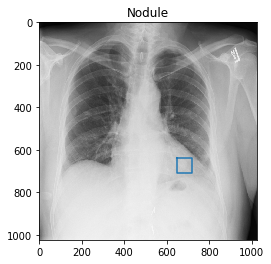

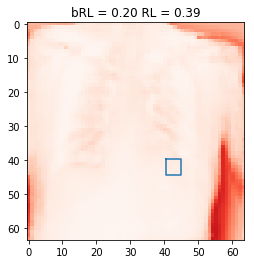

/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/00010071_008.png


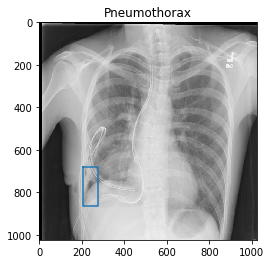

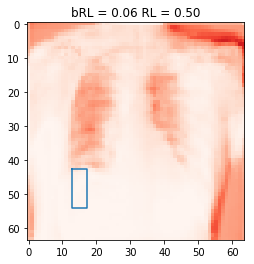

/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/00012021_054.png


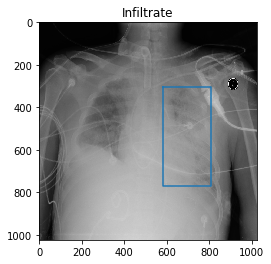

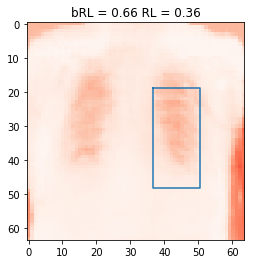

/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/00012021_081.png


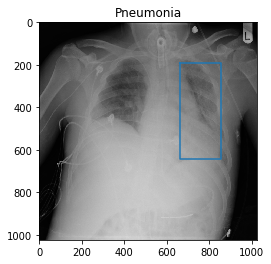

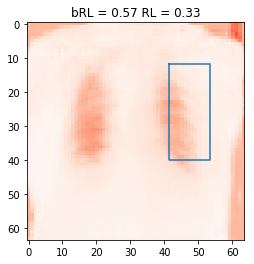

/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/00012045_005.png


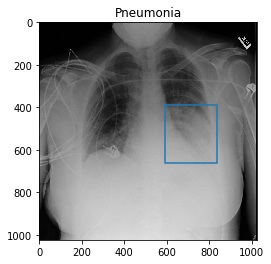

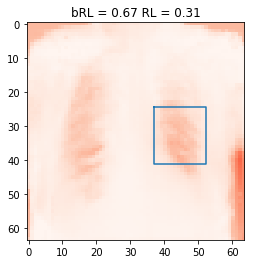

/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/00012045_009.png


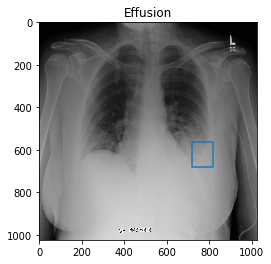

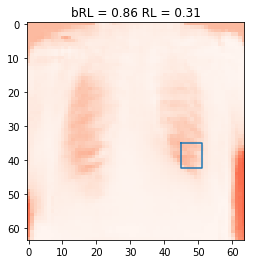

/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/00012045_019.png


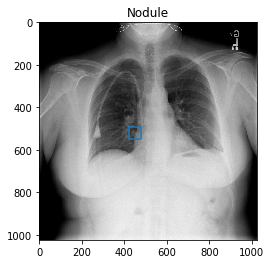

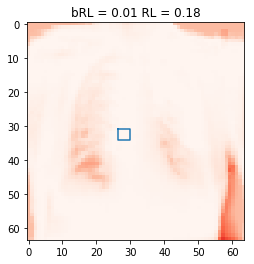

/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/00012048_007.png


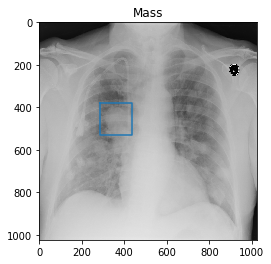

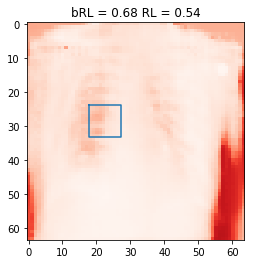

/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/00015583_000.png


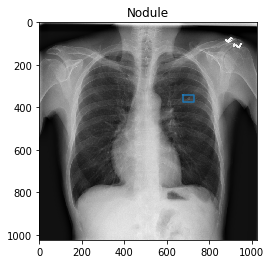

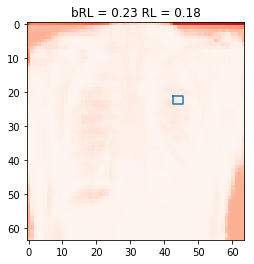

/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/00019625_002.png


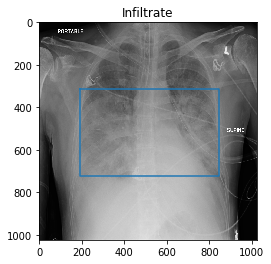

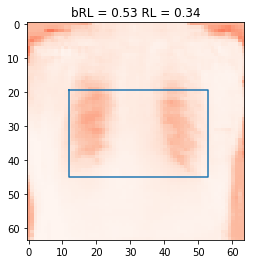

/media/vince/MILA/Chest_data/ChestXray-NIHCC-2/00020000_000.png


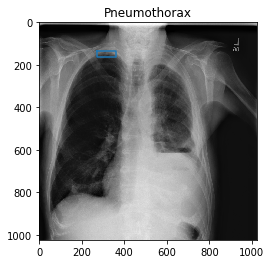

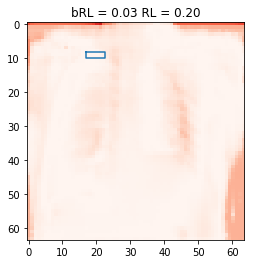

In [12]:
Printed = 0
for imgf in sorted(bbox.keys()):
    
    
    ptf = datadir+"images/"+imgf
    if not os.path.isfile(ptf):
        continue
    im = misc.imread(ptf)
    if len(im.shape) > 2:
        im = im[:, :, 0]
    #Add color chanel
    im = im[:,:,None]
    padding = 0
    if im.shape[0] > im.shape[1]:
        padding = (int((im.shape[0]-im.shape[1])/2),0)
    else:
        padding = (0,int((im.shape[1]-im.shape[0])/2))

    data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Pad(padding,fill=0)
    ])
    pim = data_transforms(im)
    print(datadir+imgf)
    plt.imshow(pim)

    x = [bbox[imgf]["x"],bbox[imgf]["x"]+bbox[imgf]["w"]]
    y = [bbox[imgf]["y"],bbox[imgf]["y"]+bbox[imgf]["h"]]
    plt.plot([x[0],x[0],x[1],x[1],x[0]],[y[0],y[1],y[1],y[0],y[0]]) 

    plt.title(bbox[imgf]["lab"])



    plt.show()
    
    
    tim = transforms.functional.to_tensor(transforms.functional.resize(pim,isize))
    #plt.imshow(tim[0],cmap="gray",vmin=0,vmax = 1)

    X = tim.reshape(1,1,isize,isize)
    z = GenZ(X)
    Xr = GenX(z)


    DiffX = Xr - X

    if torch.cuda.is_available():
        DiffX = DiffX.cpu()

    DiffX = DiffX.detach().numpy()
    DiffX = np.power(DiffX,2)
    RecLoss = [np.sqrt(np.mean(x)) for x in DiffX]
    
    x = [bbox[imgf]["x"]/1024*isize,bbox[imgf]["x"]/1024*isize+bbox[imgf]["w"]/1024*isize]
    y = [bbox[imgf]["y"]/1024*isize,bbox[imgf]["y"]/1024*isize+bbox[imgf]["h"]/1024*isize]
    
    xbound = DiffX[0][0][int(y[0]+0.5):int(y[1]+0.5),int(x[0]+0.5):int(x[1]+0.5)]
    
    plt.imshow(DiffX[0][0],cmap="Reds",vmax=4,vmin=0)
    plt.plot([x[0],x[0],x[1],x[1],x[0]],[y[0],y[1],y[1],y[0],y[0]])
    plt.title("bRL = %.2f RL = %.2f" % (np.mean(xbound),np.mean(DiffX[0][0])))
    plt.show()
    Printed += 1
    if Printed > 10:
        break


In [13]:
Printed = 0
Ratios = []
for imgf in sorted(bbox.keys()):
    
    
    ptf = datadir+"images/"+imgf
    if not os.path.isfile(ptf):
        continue
    im = misc.imread(ptf)
    if len(im.shape) > 2:
        im = im[:, :, 0]
    #Add color chanel
    im = im[:,:,None]
    padding = 0
    if im.shape[0] > im.shape[1]:
        padding = (int((im.shape[0]-im.shape[1])/2),0)
    else:
        padding = (0,int((im.shape[1]-im.shape[0])/2))

    data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Pad(padding,fill=0)
    ])
    pim = data_transforms(im)

    
    
    tim = transforms.functional.to_tensor(transforms.functional.resize(pim,isize))
    #plt.imshow(tim[0],cmap="gray",vmin=0,vmax = 1)

    X = tim.reshape(1,1,isize,isize)
    z = GenZ(X)
    Xr = GenX(z)


    DiffX = Xr - X

    if torch.cuda.is_available():
        DiffX = DiffX.cpu()

    DiffX = DiffX.detach().numpy()
    DiffX = np.power(DiffX,2)
    RecLoss = [np.sqrt(np.mean(x)) for x in DiffX]
    
    x = [bbox[imgf]["x"]/1024*isize,bbox[imgf]["x"]/1024*isize+bbox[imgf]["w"]/1024*isize]
    y = [bbox[imgf]["y"]/1024*isize,bbox[imgf]["y"]/1024*isize+bbox[imgf]["h"]/1024*isize]
    
    xbound = DiffX[0][0][int(y[0]+0.5):int(y[1]+0.5),int(x[0]+0.5):int(x[1]+0.5)]
    
    ratio = np.mean(xbound)/np.mean(DiffX[0][0])
    print(ratio,bbox[imgf]["lab"])
    Ratios.append(ratio)

/media/vince/anaconda3/envs/xray/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


0.51812595 Nodule
0.116860084 Pneumothorax
1.8391944 Infiltrate
1.696785 Pneumonia
2.1714077 Pneumonia
2.7862844 Effusion
0.030335573 Nodule
1.2615281 Mass
1.2870665 Nodule
1.544796 Infiltrate
0.1270687 Pneumothorax
0.65824825 Infiltrate
1.2495204 Cardiomegaly
0.8197659 Nodule
2.687509 Nodule


In [14]:
Ratios

[0.51812595,
 0.116860084,
 1.8391944,
 1.696785,
 2.1714077,
 2.7862844,
 0.030335573,
 1.2615281,
 1.2870665,
 1.544796,
 0.1270687,
 0.65824825,
 1.2495204,
 0.8197659,
 2.687509]